In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_csv('SJ001_merge_1day_full.csv')
df.head()

,SITE_NO,DATE,TIME,GEN_ENERGY,TEMPERATURE,SOLAR_IRRADIANCE,WIND_SPEED,MODULE_TEMPERATURE,POP,REH,SKY,T3H,WSD
0,SJ001,245,5.000000,0.0,0.00,0.0,0.0,0.0000,10,85,2,16,0.4
1,SJ001,245,5.166667,0.0,0.00,0.0,0.0,0.0000,10,85,2,16,0.4
2,SJ001,245,5.333333,0.0,0.00,0.0,0.0,0.0000,10,85,2,16,0.4
3,SJ001,245,5.500000,0.0,0.00,0.0,0.0,0.0000,10,85,2,16,0.4
4,SJ001,245,5.666667,0.0,14.82,0.0,0.0,13.3729,10,85,2,16,0.4


In [3]:
data = df.iloc[:, 1:].values
for i in range(len(data)):
    if data[i, 2] > 500:
        data[i, 2] = (data[i-1, 2] + data[i+1, 2])/2 

In [4]:
total_e = np.zeros(int(len(df)/97)) 
interval = 97

for i in range(int(len(df)/97)):
    total_e[i] = np.sum(data[i*interval: (i+1)*interval, 2])

In [5]:
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
gen_max = total_e.max()
total_e = total_e / gen_max

In [99]:
interval = 97
# input_size = 6
input_size = 7

train_num = 520

# input_series = np.zeros((train_num, 1, input_size))
input_series = np.zeros((train_num, interval, input_size))
target_series = np.zeros((train_num, 1, 1))

for i in range(train_num):
#     input_series[i, :, 0] = np.average(data[i*interval: (i+1)*interval, 0])
#     input_series[i, :, 1:6] = np.average(data[i*interval: (i+1)*interval, -5:], axis=0)
    input_series[i, :, 0:2] = data[i*interval: (i+1)*interval, 0:2]
    input_series[i, :, 2:7] = data[i*interval: (i+1)*interval, -5:]
    
    target_series[i, :, :] = total_e[i]

input_series = torch.from_numpy(input_series).to(device)
    
X_train = input_series
y_train = torch.from_numpy(target_series).to(device)

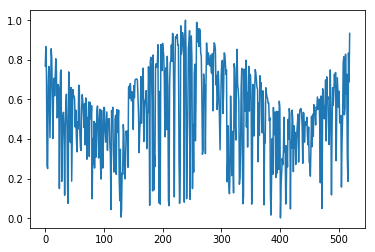

In [78]:
plt.plot(y_train.cpu().numpy().flatten())

In [107]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, num_layers = self.num_layers, batch_first = True)

        # Define the output layer
        self.out = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self, batch_size):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))

    def forward(self, input, hidden):
        input = input.float()
        batch_size = input.shape[0]
        lstm_out, lstm_hidden = self.lstm(input, hidden)
        output = F.relu(self.out(lstm_out[:, -1:, :]))
        return output, lstm_hidden

Epoch  1 MSE:  0.07473032176494598
Epoch  2 MSE:  0.03508637472987175
Epoch  3 MSE:  0.029661839827895164
Epoch  4 MSE:  0.029019474983215332
Epoch  5 MSE:  0.029442813247442245
Epoch  6 MSE:  0.029426997527480125
Epoch  7 MSE:  0.03008435107767582
Epoch  8 MSE:  0.03139728307723999
Epoch  9 MSE:  0.033468425273895264
Epoch  10 MSE:  0.03380802273750305
Epoch  11 MSE:  0.03443945571780205
Epoch  12 MSE:  0.03593602031469345
Epoch  13 MSE:  0.041865892708301544
Epoch  14 MSE:  0.03827847167849541
Epoch  15 MSE:  0.033327143639326096
Epoch  16 MSE:  0.028706824406981468
Epoch  17 MSE:  0.026535484939813614
Epoch  18 MSE:  0.03181064873933792
Epoch  19 MSE:  0.02984500490128994
Epoch  20 MSE:  0.031102830544114113
Epoch  21 MSE:  0.03686182573437691
Epoch  22 MSE:  0.02309197559952736
Epoch  23 MSE:  0.028014982119202614
Epoch  24 MSE:  0.02764708921313286
Epoch  25 MSE:  0.02969176694750786
Epoch  26 MSE:  0.02630455419421196
Epoch  27 MSE:  0.023298230022192
Epoch  28 MSE:  0.0201322305

Epoch  223 MSE:  0.012332749553024769
Epoch  224 MSE:  0.008257778361439705
Epoch  225 MSE:  0.012311764992773533
Epoch  226 MSE:  0.008269432000815868
Epoch  227 MSE:  0.011585558764636517
Epoch  228 MSE:  0.007581498473882675
Epoch  229 MSE:  0.013276750221848488
Epoch  230 MSE:  0.009885884821414948
Epoch  231 MSE:  0.009902329184114933
Epoch  232 MSE:  0.007844897918403149
Epoch  233 MSE:  0.008990922942757607
Epoch  234 MSE:  0.009767419658601284
Epoch  235 MSE:  0.007407213095575571
Epoch  236 MSE:  0.012532460503280163
Epoch  237 MSE:  0.010878504253923893
Epoch  238 MSE:  0.01259604562073946
Epoch  239 MSE:  0.008342757821083069
Epoch  240 MSE:  0.008846709504723549
Epoch  241 MSE:  0.006397551391273737
Epoch  242 MSE:  0.007961558178067207
Epoch  243 MSE:  0.016896706074476242
Epoch  244 MSE:  0.011841874569654465
Epoch  245 MSE:  0.010615555569529533
Epoch  246 MSE:  0.009007973596453667
Epoch  247 MSE:  0.011427285149693489
Epoch  248 MSE:  0.008432015776634216
Epoch  249 MS

Epoch  439 MSE:  0.006365932524204254
Epoch  440 MSE:  0.004548635799437761
Epoch  441 MSE:  0.006341820117086172
Epoch  442 MSE:  0.004911703523248434
Epoch  443 MSE:  0.0035480286460369825
Epoch  444 MSE:  0.008808224461972713
Epoch  445 MSE:  0.005786667112261057
Epoch  446 MSE:  0.004843259230256081
Epoch  447 MSE:  0.007388788275420666
Epoch  448 MSE:  0.0044257743284106255
Epoch  449 MSE:  0.003365046577528119
Epoch  450 MSE:  0.005217946134507656
Epoch  451 MSE:  0.00612142588943243
Epoch  452 MSE:  0.006289380136877298
Epoch  453 MSE:  0.0030332074966281652
Epoch  454 MSE:  0.008036456070840359
Epoch  455 MSE:  0.008721652440726757
Epoch  456 MSE:  0.004386706743389368
Epoch  457 MSE:  0.006085887085646391
Epoch  458 MSE:  0.0029328647069633007
Epoch  459 MSE:  0.0024708646815270185
Epoch  460 MSE:  0.008228850550949574
Epoch  461 MSE:  0.005049756728112698
Epoch  462 MSE:  0.004139425233006477
Epoch  463 MSE:  0.004330398049205542
Epoch  464 MSE:  0.0035386614035815
Epoch  465

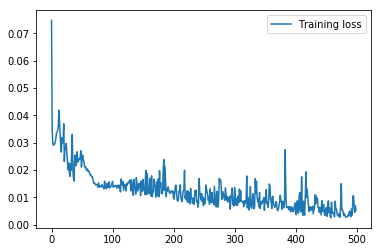

In [109]:
learning_rate = 1e-2
num_epochs = 500

model = LSTM(input_dim= input_size, hidden_dim=8, output_dim=1, num_layers=1).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
max_grad_norm = 1.0

# Train model

hist = np.zeros(num_epochs)
batch_size = 20
for t in range(num_epochs):
    for b in range(int(train_num / batch_size)):
        lstm_hidden = model.init_hidden(batch_size=batch_size)
        #loss_fn = torch.nn.MSELoss(size_average=False)
        lstm_input = X_train[batch_size*b:batch_size*(b+1), :, :]
        lstm_out, lstm_hidden = model(lstm_input, lstm_hidden)
        target = y_train[batch_size*b:batch_size*(b+1), :, :].float()
        
        loss = torch.nn.MSELoss()(lstm_out, target)        
        optimiser.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimiser.step()
        
    print("Epoch ", t+1, "MSE: ", loss.item())
    hist[t] = loss.item()


plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [103]:
df2 = pd.read_csv('SJ002_merge_1day_full.csv')
data2 = df2.iloc[:, 1:].values

In [110]:
test_total_e = np.zeros(int(len(df2)/97)) 
for i in range(int(len(df2)/97)):
    test_total_e[i] = np.sum(data2[i*interval: (i+1)*interval, 2])
    
data2 = (data2 - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
test_total_e = test_total_e / gen_max

test_num = int(len(df2)/interval)

# input_series = np.zeros((test_num, 1, input_size))
input_series = np.zeros((test_num, interval, input_size))
target_series = np.zeros((test_num, 1, 1))

for i in range(test_num):
#     input_series[i, :, 0] = np.average(data2[i*interval: (i+1)*interval, 0])
#     input_series[i, :, 1:6] = np.average(data2[i*interval: (i+1)*interval, -5:], axis=0)
    input_series[i, :, 0:2] = data2[i*interval: (i+1)*interval, 0:2]
    input_series[i, :, 2:7] = data2[i*interval: (i+1)*interval, -5:]
    
    target_series[i, :, :] = test_total_e[i]

input_series = torch.from_numpy(input_series).to(device)
    
X_test = input_series
y_test = torch.from_numpy(target_series).to(device)

In [111]:
predicted = torch.zeros(int(len(df2)/97)).to(device)
for i in range(int(len(df2)/97)):
    lstm_hidden = model.init_hidden(batch_size = 1)
    y_pred, _ = model(X_test[i:i+1], lstm_hidden)
    predicted[i] = y_pred.flatten()

In [112]:
loss = nn.MSELoss()
test_loss = loss(predicted, y_test.flatten().float())
NRMSE = torch.sqrt(test_loss)
NMAE = torch.abs(predicted-y_test.flatten().float())
NMAE = torch.sum(NMAE) * 100 / len(predicted) 
print("test_loss : %f" %(test_loss))
print("NRMSE : %f" %(NRMSE))
print("NMAE : %f" %(NMAE))

test_loss : 0.194071
NRMSE : 0.440535
NMAE : 37.744385


In [21]:
month = np.zeros(13)
from datetime import date
for i in range(12):
    month[i] = (date(2018, i+1, 1) - date(2017, 12, 31)).days
month[12] = 366
month = month.astype('int')

k = df2.values[:,1]
month_index = np.zeros(13)
m = 1
for i in range(len(df2)-interval):
    if (int(k[i+interval-1]) < month[m]) and (int(k[i+interval]) >= month[m]):
        month_index[m] = i/97
        m += 1
    else:
        pass
month_index[0] = 0
month_index[-1]=336
month_index

array([  0.,  29.,  45.,  66.,  96., 126., 156., 184., 215., 245., 275.,
       305., 336.])

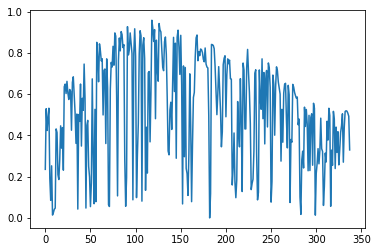

In [56]:
plt.plot(y_test.cpu().numpy().flatten())